In [250]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import scanpy as sc
import liana as li
from liana.method._pipe_utils._common import _get_props
from liana.method.sp._utils import _add_complexes_to_var
from liana._logging import _logg
from liana.method._pipe_utils import prep_check_adata, assert_covered
from scipy.sparse import csr_matrix

In [288]:
# resource = li.rs.select_resource()
import requests
import io

# read csv from link
# https://github.com/ventolab/cellphonedb-data/blob/master/data/interaction_input.csv
resource = requests.get('https://raw.githubusercontent.com/ventolab/cellphonedb-data/master/data/interaction_input.csv').content
resource = io.StringIO(resource.decode('utf-8'))
resource = pd.read_csv(resource, sep=',')
# keep only PPIs
resource = resource[resource['is_ppi']][['interactors']]
# replace + with _
resource['interactors'] = resource['interactors'].apply(lambda x: x.replace('+', '_'))
# if interactors contains two '-' replace the first one with '&
resource['interactors'] = resource['interactors'].apply(lambda x: x.replace('-', '&', 1) if x.count('-') == 2 else x)
# split by - and expand
resource = resource['interactors'].str.split('-', expand=True)
# replace & with - in the first column
resource[0] = resource[0].apply(lambda x: x.replace('&', '-'))
resource.columns = ['ligand', 'receptor']

In [290]:
# adata = sc.read_h5ad("nanostring_cosmx_human_nsclc_batch8.h5ad")

In [291]:
adata = sc.read_h5ad("nanostring_cosmx_human_nsclc_batch8.h5ad")
li.ut.spatial_neighbors(adata=adata, bandwidth=100)

nz_prop = 0.01
x_name = 'ligand'
y_name = 'receptor'
complex_sep = '_'
xy_sep = '^'
verbose = True


def _rename_means(lr_stats, entity):
    df = lr_stats.copy()
    df.columns = df.columns.map(lambda x: entity + '_' + str(x) if x != 'gene' else 'gene')
    return df.rename(columns={'gene': entity})

if complex_sep is not None:
    adata = _add_complexes_to_var(adata,
                                    np.union1d(resource[x_name].astype(str),
                                                resource[y_name].astype(str)
                                                ),
                                    complex_sep=complex_sep
                                    )

# filter_resource
resource = resource[(np.isin(resource[x_name], adata.var_names)) &
                    (np.isin(resource[y_name], adata.var_names))]

# get entities
entities = np.union1d(np.unique(resource[x_name]),
                        np.unique(resource[y_name]))
assert_covered(entities, adata.var_names, verbose=verbose)

# Filter to only include the relevant features
adata = adata[:, np.intersect1d(entities, adata.var.index)]

xy_stats = pd.DataFrame({'means': adata.X.mean(axis=0).A.flatten(), # NOTE: this A should be changed toarray)
                        'props': _get_props(adata.X)},
                        index=adata.var_names
                        ).reset_index().rename(columns={'index': 'gene'})
# join global stats to LRs from resource
xy_stats = resource.merge(_rename_means(xy_stats, entity=x_name)).merge(
                            _rename_means(xy_stats, entity=y_name))

# filter according to props
xy_stats = xy_stats[(xy_stats[f'{x_name}_props'] >= nz_prop) &
                    (xy_stats[f'{y_name}_props'] >= nz_prop)]
if xy_stats.empty:
    raise ValueError("No features with non-zero proportions")

# create interaction column
xy_stats['interaction'] = xy_stats[x_name] + xy_sep + xy_stats[y_name]

x_mat = adata[:, xy_stats[x_name]].X
y_mat = adata[:, xy_stats[y_name]].X

In [292]:
groupby = 'cell_type'

In [293]:
celltypes = pd.get_dummies(adata.obs[groupby])
ct = csr_matrix(celltypes.astype(int).values)

In [294]:
k = ct.shape[1] # number of cell types
m = x_mat.shape[1] # number of LRs
w = adata.obsp['spatial_connectivities'] # spatial weights

In [295]:
l = np.expand_dims(x_mat.toarray(), axis=1)
s = np.expand_dims(ct.toarray(), axis=2)
ls = np.multiply(l, s)
ls = ls.reshape((ls.shape[0], m * k))
# transform
ls = li.utils.zi_minmax(ls, cutoff=0.01).toarray()

wls = w.dot(csr_matrix(ls)).toarray() # NOTE: I convert to sparse for speed

# normalize by the sum of the weights
wls = wls / w.sum(axis=1)
wls[np.isnan(wls)] = 0 # nans are introduced by division by zero

/tmp/ipykernel_2128936/2018012028.py:11: RuntimeWarning: invalid value encountered in divide


In [296]:
# transform
r =  li.utils.zi_minmax(y_mat, cutoff=0.01).toarray()
ri = np.tile(r, ct.shape[1])
xy_mat = np.array(wls) * ri

In [297]:
var = pd.DataFrame(index=(
    np.repeat(celltypes.columns.astype(str), m) + # NOTE: repeat or tile?
    xy_sep + 
    np.tile(xy_stats['interaction'].astype(str), len(celltypes.columns))
    ))

In [298]:
lrdata = sc.AnnData(X=xy_mat, var=var, obs=adata.obs, uns=adata.uns, obsm=adata.obsm, varm=adata.varm, obsp=adata.obsp)

In [299]:
sc.pp.highly_variable_genes(lrdata)

In [302]:
lrdata.var[lrdata.var['highly_variable']].sort_values("dispersions_norm")

,highly_variable,means,dispersions,dispersions_norm
tumor^FN1^ITGA3_ITGB1,True,0.016601,-1.607364,0.558303
tumor^CEACAM6^CEACAM6,True,0.015876,-1.594293,0.596190
myeloid^APP^CD74,True,0.020075,-3.084157,1.000000
tumor^APP^CD74,True,0.070437,-2.121324,1.000000
tumor^AREG^EGFR,True,0.027102,-1.559469,1.000000


In [303]:
adata.layers['transformed'] = li.utils.zi_minmax(adata.X, cutoff=0.01)

/tmp/ipykernel_2128936/3987365680.py:1: ImplicitModificationWarning: Setting element `.layers['transformed']` of view, initializing view as actual.


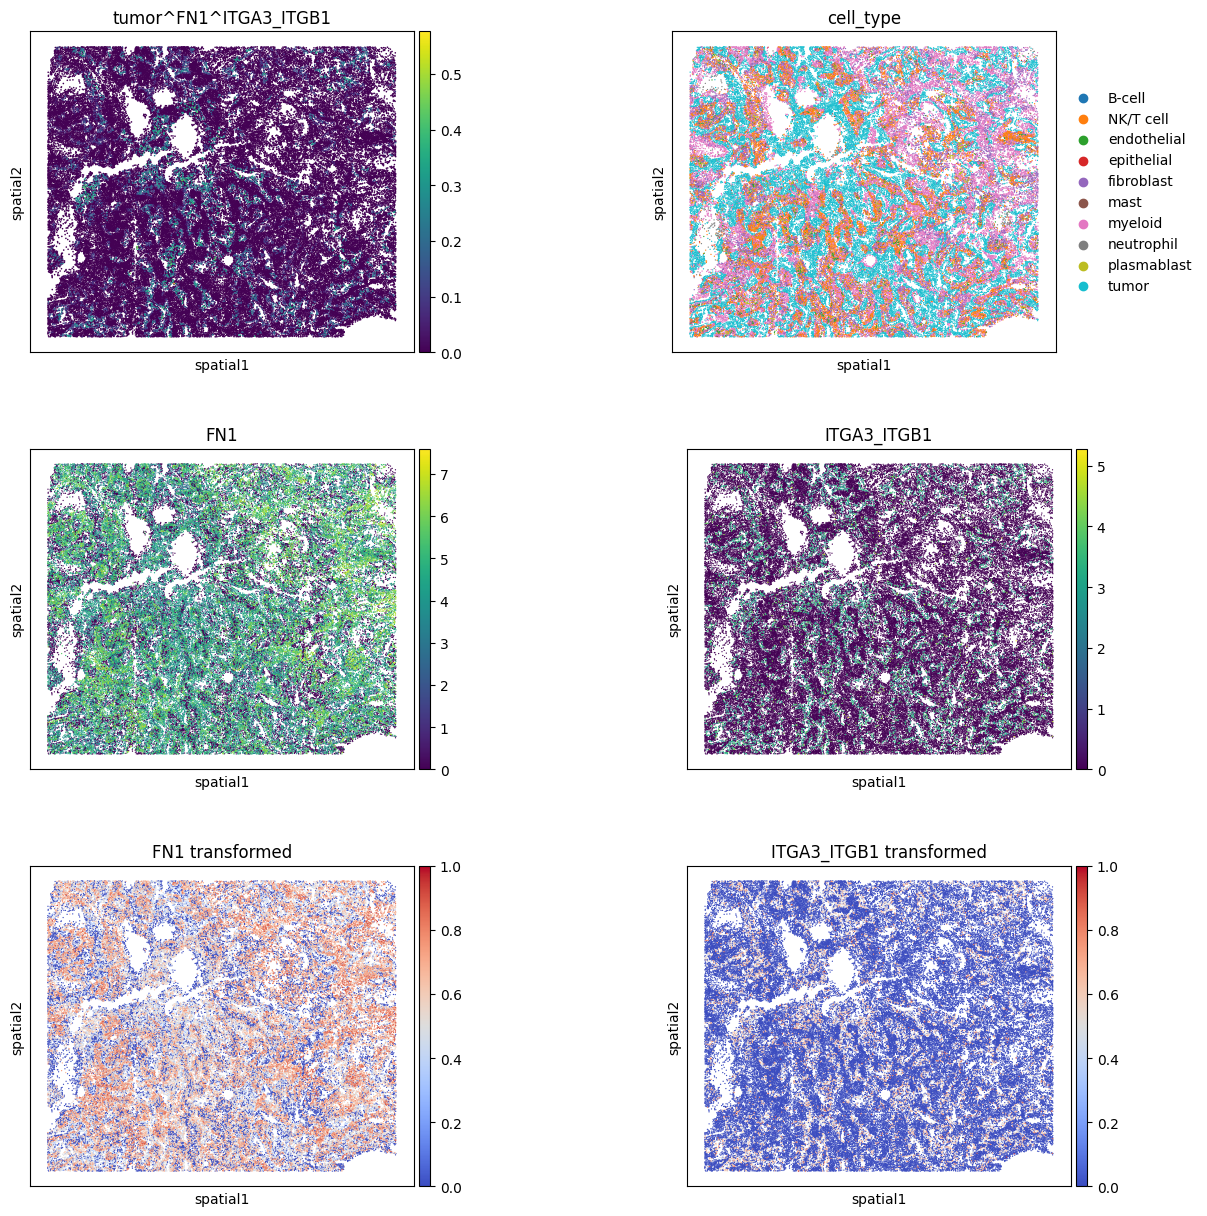

In [304]:
fig, axes = plt.subplots(3, 2, figsize=(15, 15))
plt.subplots_adjust(hspace=0.3, wspace=0.3)
axes = axes.flatten()

# Define your keys
key = 'tumor^FN1^ITGA3_ITGB1'
keys = key.split(xy_sep)

if len(keys) < 2:
    raise ValueError("The 'key' variable should contain at least two elements separated by '&'.")

ligand = keys[1]
receptor = keys[2]

adata.obs['receptor'] = (adata[:, receptor].X > 0).toarray().flatten()

sc.pl.spatial(lrdata, color=[key], spot_size=100, ax=axes[0],show=False)
axes[0].set_title(f"{key}")
sc.pl.spatial(adata, color=[groupby], spot_size=80, ax=axes[1],show=False)
axes[1].set_title(f"{groupby}")
sc.pl.spatial(adata, color=[ligand], spot_size=80, ax=axes[2], show=False)
axes[2].set_title(f"{ligand}")
sc.pl.spatial(adata, color=[receptor], spot_size=80, ax=axes[3], show=False)
axes[3].set_title(f"{receptor}")
sc.pl.spatial(adata, color=[ligand], spot_size=80, ax=axes[4], show=False, layer='transformed', cmap='coolwarm')
axes[4].set_title(f"{ligand} transformed")
sc.pl.spatial(adata, color=[receptor], spot_size=80, ax=axes[5], show=False, layer='transformed', cmap='coolwarm')
axes[5].set_title(f"{receptor} transformed")
plt.show()

## Make them global?

In [246]:
celltype_names = list(celltypes.columns.values)
interaction_names = list(xy_stats['interaction'].values)

t = ct.toarray() / t.sum(axis=0) # NOTE: scaled by the sum of each cell type

In [247]:
cube = (t.T @ lrdata.X).reshape((k, m, k))

In [266]:
values = cube.flatten()
celltype1 = np.tile(celltype_names, m * k)
interaction = np.tile(np.tile(interaction_names, k), k)
celltype2 = np.tile(celltype_names, m * k)
names = [f"{celltype1[i]}{xy_sep}{celltype2[i]}{xy_sep}{interaction[i]}" for i in range(len(values))]
values = cube.flatten()
df = pd.DataFrame({
    'name': names,
    'value': values
})

In [268]:
df.sort_values('value', ascending=False).head(10)

,name,value
76472,endothelial_endothelial_APP^CD74,0.149213
77095,mast_mast_TIMP1^CD63,0.133068
77150,B-cell_B-cell_COL18A1^ITGA3,0.131742
76612,endothelial_endothelial_COL1A1^DDR1,0.104027
76467,neutrophil_neutrophil_HLA-A^ERBB2,0.086498
76884,fibroblast_fibroblast_MIF^EGFR,0.083745
76886,myeloid_myeloid_MIF^TNFRSF14,0.076109
51366,myeloid_myeloid_SPP1^CD44,0.074333
77129,tumor_tumor_GSTP1^EGFR,0.073569
51335,mast_mast_S100A9^CD68,0.072867
